In [ ]:
## Visualization of data points

100 25 200


<AxesSubplot:xlabel='x', ylabel='y'>

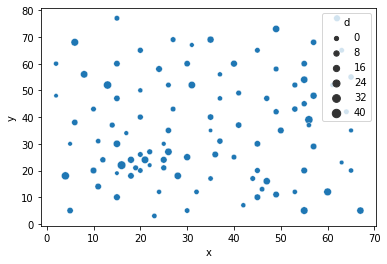

In [2]:
with open('rcdata/r103.txt', 'r', encoding = 'utf-8') as f:
    [f.readline() for i in range(4)]
    n_locations = 100
    n_vehicles, cap = [int(x) for x in f.readline().split()]
    data = []
    [f.readline() for i in range(4)]
    for i in range(n_locations + 1):
        data.append([float(x) for x in f.readline().split()[1:]])

data = np.array(data)
print(n_locations, n_vehicles, cap)
dataT = data.T
a = pd.DataFrame({'x':dataT[0], 'y':dataT[1] , 'd':dataT[2]})
sns.scatterplot(data=a, x='x', y='y', size='d', palette="deep")

## Create a graph

In [3]:
class Graph:
    def __init__(self, x, y) -> None:
        self.n = n = len(x)
        self.x = np.array(x, dtype=float)
        self.y = np.array(y, dtype=float)
        self.edges = np.zeros(shape=(n,n), dtype=float)

        for i in range(self.n):
            for j in range(self.n):
                self.edges[i,j] = dist([x[i], y[i]], [x[j], y[j]])

        xf = 10000
        for i in range(self.n):
            self.edges[i,i] = xf

In [4]:
graph = Graph(dataT[0], dataT[1])

## Ant Definition

In [5]:
class Ant:
    def __init__(self, tour) -> None:
        self.tour = tour
        self.cost = np.inf
        self.veh = np.inf
        self.visi = 0

    def __repr__(self) -> str:
        return f'Ant(tour={self.tour}, o={self.cost}, veh={self.veh}, visi={self.visi})'

    def __lt__(self, other):
        return self.cost < other.cost

## Objective function

In [6]:
def maco_objective(tour):
    dist_tour, cap = 0, 0
    time_tour, max_cap = 0, 200
    for i in range(len(tour)-1):
        ni, nj = tour[i], tour[i+1]
        tij = dist([data[ni,0], data[ni,1]], [data[nj,0], data[nj,1]])
        dist_tour += tij
        if nj == 0:
            time_tour, cap = 0, 0
        else:
            cap += data[nj,2]
            time_tour = max(time_tour + tij, data[nj,3])
            assert(data[nj,3] <= time_tour <= data[nj,4])
            assert(cap <= max_cap)
            time_tour += data[nj,5]
    return dist_tour

## Calculating feasible solution

In [7]:
def feasible_initial_solution(n, graph, data, cap):
    tour = [0]
    vis = np.zeros(n)
    vis[0] = 1
    curr_time = 0
    while np.sum(vis) != n:
        last = tour[-1]
        mins = np.argsort(graph.edges[last])
        for x in mins:
            if  x and not vis[x] and (curr_time + graph.edges[last,x] <= data[x,4]):
                curr_time = max(curr_time + graph.edges[last][x], data[x, 3])
                curr_time += data[x,5]
                tour.append(x)
                vis[x] = 1
                break
        else:
            curr_time = 0
            tour.append(0)
    if tour[-1] !=0:
        tour.append(0)
    sol = Ant(tour)
    sol.cost = maco_objective(sol.tour)
    sol.veh = sum([x == 0 for x in sol.tour]) - 1
    sol.visi = len(set(tour))
    return sol

test = feasible_initial_solution(101, graph, data)
print(test)

TypeError: feasible_initial_solution() missing 1 required positional argument: 'cap'

## Higher Level ACO Function

In [8]:
# def maco_vrptw(n, graph, data):
#     psi_gb = feasible_initial_solution(n, graph, data)
#     for i in range(10):
#         veh = np.sum([x == 0 for x in test]) - 1
#         while 1:
#             psi1 = aco_vehicle(n, veh-1, np.copy(data))
#             if psi1 < psi_gb:
#                 psi_gb = psi1
#             psi2 = aco_time(n, veh, np.copy(data))
#             if psi2 < psi_gb:
#                 psi_gb = psi2

## ACO Vehicle function

In [9]:
def infeasible_solution(n, graph, data, veh, cap):
    tour = [0]
    vis = np.zeros(n)
    vis[0] = 1
    curr_time = 0
    load = 0
    while np.sum(vis) != n:
        last = tour[-1]
        mins = np.argsort(graph.edges[last])
        for x in mins:
            if  x and not vis[x] and (curr_time + graph.edges[last,x] <= data[x,4]) and load + data[x, 2]<= cap:
                curr_time = max(curr_time + graph.edges[last][x], data[x, 3])
                curr_time += data[x,5]
                load += data[x, 2]
                tour.append(x)
                vis[x] = 1
                break
        else:
            curr_time = 0
            tour.append(0)
            if sum([x == 0 for x in tour]) - 1 == veh:
                break
    if tour[-1] !=0:
        tour.append(0)
    sol = Ant(tour)
    sol.cost = maco_objective(sol.tour)
    sol.veh = sum([x == 0 for x in sol.tour]) - 1
    sol.visi = len(set(tour))
    return sol

In [8]:
def valid_tour(tour, n, data, graph, max_cap):
    dist_tour = 0
    cap = 0
    time_tour = 0
    for i in range(len(tour)-1):
        ni, nj = tour[i], tour[i+1]
        tij = dist([data[ni,0], data[ni,1]], [data[nj,0], data[nj,1]])
        dist_tour += tij
        if nj == 0 or nj >= n:
            time_tour, cap = 0, 0
        else:
            cap += data[nj,2]
            time_tour = max(time_tour + tij, data[nj,3])
            if not (data[nj,3] <= time_tour <= data[nj,4]):
                return False
            if not (cap <= max_cap):
                return False
            time_tour += data[nj,5]
    return True

In [9]:
def new_active_ant(local, incom, n, data, graph, cap, rho):
    tour = [np.random.choice([0] + list(range(10, len(data))), 1)]
    curr_time = 0
    load = 0
    vis = np.zeros(n + veh)
    vis[tour[0]] = 1
    eta = np.zeros(n+veh, dtype=float)

    # first insertion of nodes by ACO
    feasible_node = True
    while feasible_node:

        feasible_node = False
        last = tour[-1]
        for x in range(n + veh):
            if not vis[x] and (curr_time + graph.edges[last,x] <= data[x,4]) and load + data[x, 2] <= cap:
                feasible_node = True
                deliv_time = max(curr_time + graph.edges[last][x], data[x, 3])
                delta_time = deliv_time - curr_time
                distance = delta_time * (data[x,4] - curr_time)
                distance = max(1, distance - incom[x])
                eta[x] = 1 / distance
            else:
                eta[x] = 0

        if not feasible_node:
            break

        probs = (tau[last]) * (eta ** beta)
        probs = probs / np.sum(probs)
        
        next = np.random.choice(n, p=probs)
        tour.append(next)
        vis[next] = 1
        curr_time = max(curr_time + graph.edges[last][x], data[x, 3])
        curr_time += data[x,5]
        load += data[x, 2]

        tau[last][next] = (1 - rho) * tau[last][next] + rho * tau0

    # there still may remain some non inserted nodes
    for x in range(n + veh):
        if not vis[x]:
            for g in range(len(tour) + 1):
                tc = tour.copy()
                tc.insert(g, x)
                if valid_tour(tc, n, data, graph, cap):
                    tour = tc
    
    sol = Ant(tour)
    sol.cost = maco_objective(sol.tour)
    sol.veh = sum([x == 0 or x >= n for x in sol.tour]) - 1
    sol.visi = sum(vis[:n])
    return sol

In [10]:
def aco_vehicle(n, veh, data, n_ants, psi_gb, rho):

    graph = Graph(data.T[0], data.T[1])

    # initial solution, may be infeasible
    psi_vei = infeasible_solution(n, graph, data, veh)
    print(psi_vei)

    # inserting duplicate depots
    np.append(data, np.repeat([data[0]], veh, axis=0), axis=0)

    # update graph
    graph = Graph(data.T[0], data.T[1])

    # creating tau matrix
    tau = np.full(graph.edges.shape, 10/np.sum(graph.edges))

    for i in range(10):
        ants = [Ant([]) for i in range(n_ants)]

        incom = np.zeros(n)
        for i in range(n_ants):
            self.ants[i] = new_active_ant(local=False, 
                            incom=incom, n=n, veh=veh, data=data, graph=graph, tau=tau)
            for x in self.ants[i].tour:
                incom[j] += 1
 
        for i in range(n_ants):
            if self.ants[i].vehicles > psi_vei.vehicles:
                psi_vei = copy.deepcopy(self.ants[i])
                incom = np.zeros(n)
                if self.ants[i].vehicles == n + 1:
                    return self.ants[i]
            
        # updating tau values
        tau = (1-rho) * tau
        for j in range(len(psi_vei) - 1):
            cur, nxt = psi_vei.tour[j:j+2]
            tau[cur][nxt] += 1/psi_vei.cost
            tau[nxt][cur] += 1/psi_vei.cost
        for j in range(len(psi_gb) - 1):
            cur, nxt = psi_gb.tour[j:j+2]
            tau[cur][nxt] += 1/psi_gb.cost
            tau[nxt][cur] += 1/psi_gb.cost

    return psi_vei

aco_vehicle(n=101, veh=25, data=data, n_ants=10)

TypeError: aco_vehicle() missing 2 required positional arguments: 'psi_gb' and 'rho'

## ACO Time function

In [11]:
def split_lists(lst):
    lst = ' '.join(str(x) for x in lst).split(' 0 ')
    llst = []
    for x in lst:
        go = x.split(' ')
        go = [int(x) for x in go]
        if go[0] != 0:
            go.insert(0,0)
        if go[-1] != 0:
            go.insert(len(go),0)
        llst.append(go)
    return llst

In [12]:
split_lists(test)

TypeError: 'Ant' object is not iterable

In [12]:
def make_plots(tour, graph):
  fig, ax =  plt.subplots(1, 1, figsize=(11, 5))

  # third plot, for tour after optimization
  for tour in split_lists(tour):
    plot_x = []
    plot_y = []
    for i in tour:
        plot_x.append(graph.x[i])
        plot_y.append(graph.y[i])

    ax.set_ylabel('Y')
    ax.set_xlabel('X')
    ax.plot(plot_x, plot_y, marker='o', linestyle='dashed')

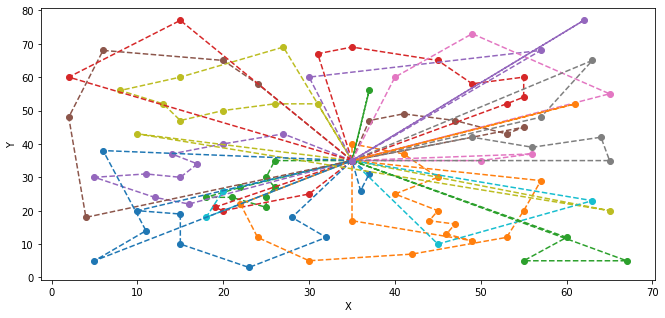

In [13]:
make_plots(test, graph)

In [1]:
1 / (2018 * 101)

4.906338007438009e-06

In [16]:
101/np.sum(graph.edges)

7.465379830359327e-05